In [1]:
import requests
import json
import pickle
from bs4 import BeautifulSoup as bs
import re

In [2]:
def get_seasons():
    seasons = range(1,11)
    season_list = []
    season_url = 'https://adventuretime.fandom.com/api/v1/Articles/List?expand=1&category=season+{}&namespaces=0&limit=50'
    for season in seasons:
        r = requests.get(season_url.format(season)).text
        json_r = json.loads(r)
        season_list.append(json_r)
    return season_list

# creates a dictionary with episode title as key and its season as value
episode_season = {}
for i, season in enumerate(get_seasons()):
    for episode in season['items']:
        title = episode['url'][6:]
        if ('Adventure_Time_Short:' in title or
            'Frog_Seasons:' in title or
            'Islands' == title or
            'Stakes' == title or
            'Elements' == title or
            'MonthBomb' == title): # a few titles that snuck in which are not episodes
            continue
        episode_season[title] = i+1

# creates a dictionary with season number as key and a list of episodes as value
season_episodes = {episode_season[e]:[]  for e in episode_season}
for ep in episode_season:
    season_episodes[episode_season[ep]].append(ep)

# returns a list of lines with charater names
def get_transcript(title):
    season_num = episode_season[title]
    transcript = pickle.load(open(f'seasons/season{season_num}/transcripts/{title}.txt', 'rb'))
    return transcript

# returns a list of lines without character names
def get_transcript_text(title):
    transcript = get_transcript(title)
    text = [re.sub(r'^.*?:\s*', '', line) for line in transcript]
    return text

# returns a dictionary with each character as key and their respective lines
# as values stored as a list
def get_transcript_characters(title):
    transcript = get_transcript(title)
    characters = [re.search(r'^.*?:', line).group()[:-1] for line in transcript]
    character_lines = {}
    for character in characters:
        character_lines[character] = []
    for line in transcript:
        character = re.search(r'^.*?:', line).group()[:-1]
        text = re.sub(r'^.*:\s', '', line)
        character_lines[character].append(text)
    return character_lines

def get_article(title):
    season_num = episode_season[title]
    article = pickle.load(open(f'seasons/season{season_num}/articles/{title}.json', 'rb'))
    return article

def get_major_characters(title):
    major_characters_raw = next(x for x in get_article(title)['sections'] 
                                    if (x['title'].lower().replace(u'\xa0', u' ') == 'major characters'
                                    or x['title'].lower() == 'main characters')) # workaround until wiki updates
    major_characters = major_characters_raw['content'][0]['elements']
    major_characters = [c['text'] for c in major_characters]
    major_characters = [c.replace(u'\xa0', u' ') for c in major_characters]
    major_characters = [re.sub(r'\s*\(.*?\)', '', c) for c in major_characters if c != 'Snail']
    return major_characters

def get_minor_characters(title):
    minor_characters_raw = next(x for x in get_article(title)['sections'] 
                                    if x['title'].lower() == 'minor characters')
    minor_characters = minor_characters_raw['content'][0]['elements']
    minor_characters = [c['text'] for c in minor_characters]
    minor_characters = [c.replace(u'\xa0', u' ') for c in minor_characters]
    minor_characters = [re.sub(r'\s*\(.*?\)', '', c) for c in minor_characters if c != 'Snail']
    return minor_characters

def get_all_characters(title):
    return get_major_characters(title) + get_minor_characters(title)

In [22]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
fig_size = (16,8)
%matplotlib inline
from itertools import combinations
from fa2 import ForceAtlas2
import community
import matplotlib.style as style
style.use('ggplot')

In [4]:
# makes a directed graph and an undirected graph from a list
# of season numbers i.e. get_graphs_from([1,2])
def get_graphs_from(seasons):
    DG = nx.DiGraph()
    for season in seasons:
        for episode_title in season_episodes[season]:
            if episode_title == 'Come_Along_With_Me': # excludes come along with me since it is an anomaly
                continue
            DG.add_edges_from(combinations(get_all_characters(episode_title),2))
    G = DG.to_undirected()
    return DG, G

DG, G = get_graphs_from(range(1,11))
degree = list(dict(DG.degree()).values())
print(f"Number of nodes in network: {len(DG.nodes)}")
print(f"Number of edges in network: {len(DG.edges)}")

Number of nodes in network: 956
Number of edges in network: 13075


In [5]:
# creates a dictionary with season number as key and a tuple of directed and
# undirected graph as value for each season
network_season = {i:get_graphs_from([i]) for i in range(1,11)}

def sort_graph_property(graph):
    return sorted(dict(graph).items(), key = lambda x: x[1], reverse = True)

# sorted out degree per season and for entire series
out_degree_season = [sort_graph_property(network[0].out_degree)
                      for network in list(network_season.values())]
out_degree_all = sort_graph_property(DG.out_degree)

# sorted in degree per season and for entire series
in_degree_season = [sort_graph_property(network[0].in_degree)
                      for network in list(network_season.values())]
in_degree_all = sort_graph_property(DG.in_degree)

# sorted degree per season and for entire series
degree_season = [sort_graph_property(network[0].degree)
                      for network in list(network_season.values())]
degree_all = sort_graph_property(DG.degree)


# sorted betweenness centrality per season and for entire series
betweenness_season = [sort_graph_property(nx.algorithms.centrality
                                          .betweenness_centrality(network[0]))
                      for network in list(network_season.values())]
betweenness_all = sort_graph_property(nx.algorithms.centrality
                                      .betweenness_centrality(DG))

# sorted eigenvector centrality per season and for entire series
eigenvector_season = [sort_graph_property(nx.algorithms.centrality
                                        .eigenvector_centrality(network[0]))
                      for network in list(network_season.values())]
eigenvector_all = sort_graph_property(nx.algorithms.centrality
                                      .eigenvector_centrality(DG))

# sorted degree centrality per season and for entire series
degree_centr_season = [sort_graph_property(nx.algorithms.centrality
                                        .degree_centrality(network[0]))
                      for network in list(network_season.values())]
degree_centr_all = sort_graph_property(nx.algorithms.centrality.degree_centrality(DG))

We start off by looking at network statistics for the characters across the entire series to get a sense of what to look for.

**Exploration of character importance (degree and centrality measurements)**

In [6]:
def format_table_data(data):
    return ['{}: {}'.format(r[0], round(r[1],3)) for r in data]

pd.DataFrame({'Out-degree': format_table_data(out_degree_all[:10]),
              'In-degree': format_table_data(in_degree_all[:10]),
              'Total degree': format_table_data(degree_all[:10])})

,Out-degree,In-degree,Total degree
0,Finn: 832,BMO: 186,Jake: 978
1,Jake: 820,Candy People: 173,Finn: 965
2,BMO: 363,Jake: 158,BMO: 549
3,Princess Bubblegum: 339,Finn: 133,Princess Bubblegum: 461
4,Ice King: 320,Lady Rainicorn: 132,Ice King: 448
5,Marceline: 237,Ice King: 128,Marceline: 336
6,Lumpy Space Princess: 216,Princess Bubblegum: 122,Candy People: 303
7,Lady Rainicorn: 158,Gunter: 106,Lumpy Space Princess: 302
8,Gunter: 150,Tree Trunks: 105,Lady Rainicorn: 290
9,Peppermint Butler: 142,Peppermint Butler: 101,Gunter: 256


During the prelimenary analysis we noticed that the Snail character had an oddly large In-degree (of about 800). This is because the Snail appears in _every single episode_ for a few frames waving at the viewer as a sort of easter egg for the attentive viewer. This is apparently enough for it to be considered a minor character according those who've entered major and minor characters for each episode.

This is an indication that we should either drop the Snail from the data or focus on out-degree as our primary degree measurement. We decided to drop the character entirely since it doesn't represent significant importance throughout the show.

In [7]:
pd.DataFrame({'Betweenness': format_table_data(betweenness_all[:10]),
              'Eigenvector': format_table_data(eigenvector_all[:10]),
              'Degree centrality': format_table_data(degree_centr_all[:10])})

,Betweenness,Eigenvector,Degree centrality
0,Jake: 0.195,Candy People: 0.197,Jake: 1.024
1,Finn: 0.148,BMO: 0.148,Finn: 1.01
2,BMO: 0.093,Peppermint Butler: 0.14,BMO: 0.575
3,Princess Bubblegum: 0.071,Lady Rainicorn: 0.136,Princess Bubblegum: 0.483
4,Ice King: 0.069,Ice King: 0.134,Ice King: 0.469
5,Lady Rainicorn: 0.049,Tree Trunks: 0.131,Marceline: 0.352
6,Candy People: 0.045,Jake: 0.127,Candy People: 0.317
7,Lumpy Space Princess: 0.04,Princess Bubblegum: 0.126,Lumpy Space Princess: 0.316
8,Tree Trunks: 0.033,Mr. Pig: 0.124,Lady Rainicorn: 0.304
9,Gunter: 0.032,Wyatt: 0.12,Gunter: 0.268


In [8]:
pd.DataFrame({'season {}'.format(s+1): format_table_data(l[:5]) for s, l in enumerate(eigenvector_season)})

,season 1,season 2,season 3,season 4,season 5,season 6,season 7,season 8,season 9,season 10
0,Tree Trunks: 0.301,Mr. Goose: 0.405,Two-Headed Duck: 0.384,Scientific Parasite: 0.328,Candy People: 0.217,Candy People: 0.272,Worm: 0.246,BMO: 0.263,Lumpy Space People: 0.354,The Morrow: 0.358
1,King Worm: 0.29,Mrs. Yoder: 0.384,Mr. Pig: 0.343,Gumball Guardian: 0.304,Gunter: 0.211,King of Ooo: 0.247,Marceline's mom: 0.238,Candy People: 0.24,Wyatt: 0.33,Squirrel: 0.322
2,Lady Rainicorn: 0.27,Cat: 0.297,Tree Trunks: 0.307,Jellyfish: 0.292,BMO: 0.201,Penguins: 0.214,Spider Ghost: 0.221,The Lich: 0.229,Me-Mow: 0.307,Scorcher: 0.29
3,Centipede: 0.229,Chipmunk: 0.256,Phil: 0.275,Cow: 0.226,Gumball Guardian: 0.175,Laser Wizard: 0.21,Toronto: 0.212,Slime Princess: 0.206,Cosmic Owl: 0.285,Sir Slicer: 0.262
4,Wildberry Princess: 0.206,Owls: 0.221,Punch Bowl: 0.246,Banana Guards: 0.207,Finn: 0.16,Bufo: 0.192,Coal Man: 0.198,Gunter: 0.189,Prismo: 0.266,Ash: 0.236


This gives us an indication of which characters are interesting to look analyse further on in the notebook.

In [9]:
top_characters = list(dict(degree_all[:10]).keys())
char_degree = {c : [] for c in top_characters}

for char in char_degree.keys():
    for i, net in enumerate(network_season.values()):
        if char in dict(net[0].degree).keys():
            char_degree[char].append(net[0].degree[char] / len(season_episodes[i+1]))
        else:
            char_degree[char].append(None)

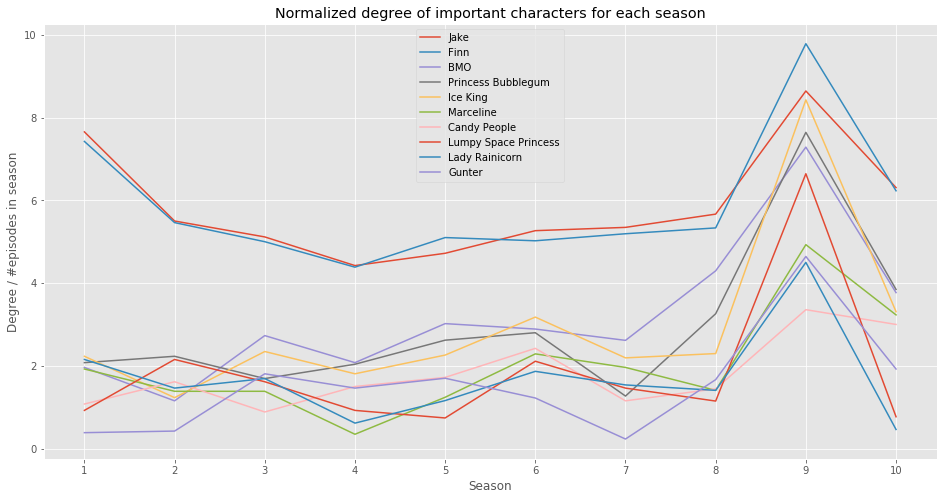

In [23]:
plt.figure(figsize=fig_size)
for char in char_degree:
    plt.plot(char_degree[char], label = char)
plt.xticks(range(10), range(1,11))
plt.legend()
plt.title("Normalized degree of important characters for each season")
plt.ylabel("Degree / #episodes in season")
plt.xlabel("Season")
plt.savefig('../normalized_degree.png')
plt.show()

Since season 9 is heavy on serialisation rather than one-off episodes it causes the out-degree of these main charaters to spike. This is because the main characters are consistently the same throughout the serialised episodes.

We also notice that Finn and Jake, the main characters of the show, take a dive at around season 4-5. This is presumably because the show introduces new characters and rely more on those as time goes on.

**Degree distribution**

We also wish to investigate which kind of network we are dealing with (random, scale-free, etc.). This is done with a degree distribution.

Our preliminary analysis showed that the episode "Come Along With Me", which is the 45 minute series finale, as opposed to the regular 10 minute episodes, skews the data from an average degree of ~27 to ~37 since it has such an immense amount of characters in the episode. Because of this anomaly we decided to drop the episode from the data.

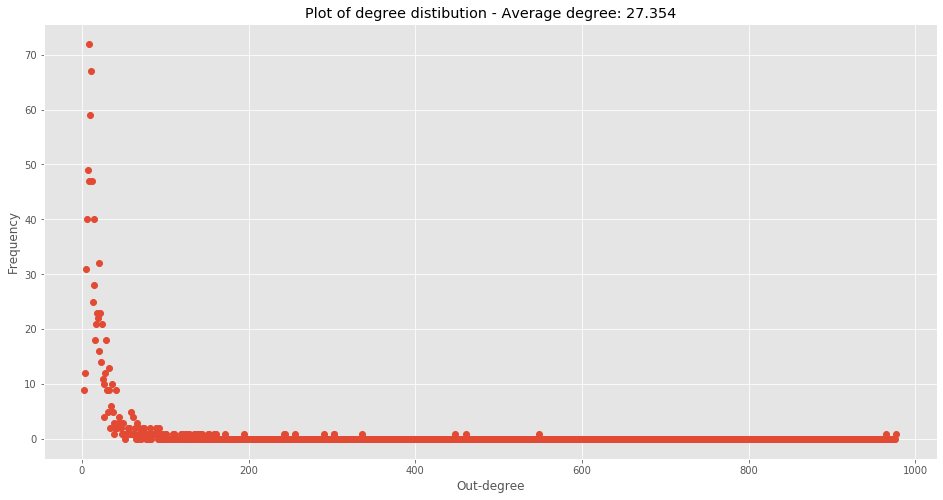

In [25]:
plt.figure(figsize=fig_size)
v = np.arange(min(degree), max(degree)+1)
h_1, b_1 = np.histogram(degree, bins = v)
plt.plot(b_1[:-1], h_1, 'o')
plt.title(f"Plot of degree distibution - Average degree: {round(np.mean(degree),3)}")
plt.xlabel("Out-degree")
plt.ylabel("Frequency")
plt.show()

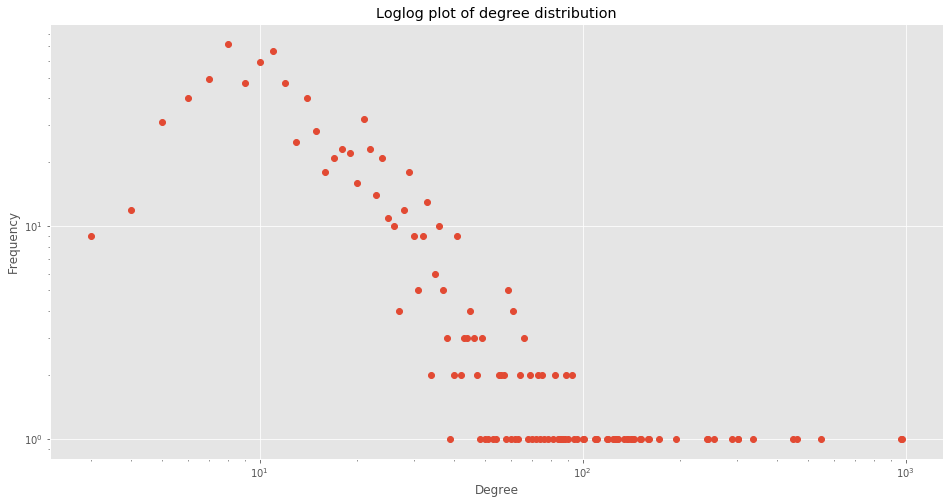

In [27]:
plt.figure(figsize=fig_size)
h_2, b_2 = np.histogram(degree, bins = v)
plt.loglog(b_2[:-1], h_2, 'o')
plt.title('Loglog plot of degree distribution')
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.savefig('../loglog.png')
plt.show()

From the loglog plot we clearly see that the degree distribution follows a poissonian distribution indicating a random network.

In [15]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,
                          linLogMode=False,
                          adjustSizes=False,
                          edgeWeightInfluence=1,

                          # Performance
                          jitterTolerance=0.01,
                          barnesHutOptimize=True,
                          barnesHutTheta=0.9,
                          multiThreaded=False,

                          # Tuning
                          scalingRatio=0.01,
                          strongGravityMode=False,
                          gravity=0.1,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:16<00:00, 123.72it/s]

BarnesHut Approximation  took  4.80  seconds
Repulsion forces  took  9.99  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.28  seconds
AdjustSpeedAndApplyForces step  took  0.46  seconds


In [16]:
# generates random colors to use for the communities
colors = ['#%02x%02x%02x' % tuple(np.random.randint(256, size = 3)) 
            for _ in range(25)]

def get_community_cmap(partition):
    color_map = []
    for com in partition.values():
        color_map.append(colors[com])
    return color_map

In [17]:
partition = community.best_partition(G)
modularity = community.modularity(partition, G)
print(f"Value of modularity found by Louvain Community Detection {modularity}")

communities = {}
for p, c in partition.items():
    communities[c] = communities.get(c, [])
    communities[c].append(p)

Value of modularity found by Louvain Community Detection 0.36169632065048424


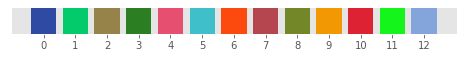

In [18]:
plt.figure(figsize=(8,.5))
plt.bar(range(len(communities.keys())),1 , color = colors)
plt.xticks(range(len(communities.keys())), range(0, len(communities.keys())))
plt.yticks([])
plt.show()

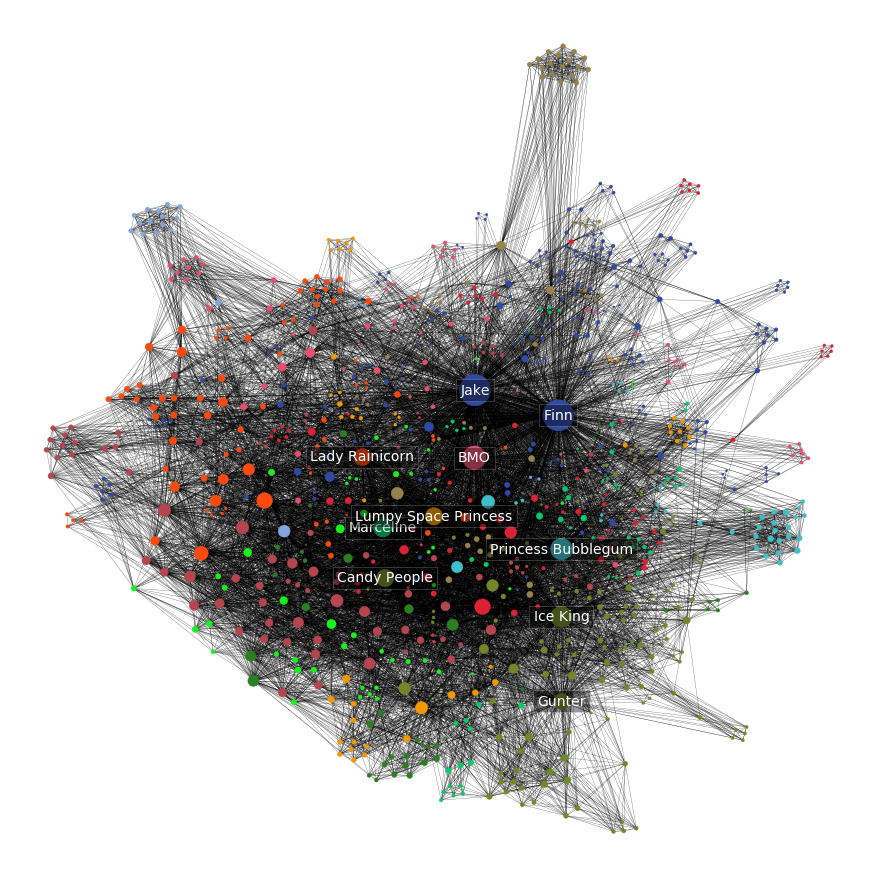

In [19]:
plt.figure(figsize=(12,12))
color_map = get_community_cmap(partition)
labels = {c:c for c in DG.nodes if c in dict(degree_all[:10]).keys()}
# labels = {c:c for c in G.nodes if c in communities[2]}
nx.draw(G, node_size = degree, pos = positions,
        width=.2, node_color = color_map, with_labels = False)
nx.draw_networkx_labels(DG, positions, labels, font_size = 14, font_color = 'w',
                        bbox=dict(facecolor='black', alpha=0.4) )
plt.savefig("../network_communities.png")
plt.show()

In [20]:
def modularity_from_nodes(G, nodes):
    subgraph = G.subgraph(nodes)
    partition = community.best_partition(subgraph)
    modularity = community.modularity(partition, subgraph)

    communities = {}
    for p, c in partition.items():
        communities[c] = communities.get(c, [])
        communities[c].append(p)
        
    return modularity, communities

princesses = [p for p in G.nodes if 'princess' in p.lower()]
princess_modularity, princess_partition = modularity_from_nodes(G, princesses)

print(f"Princess modularity {princess_modularity}")

Princess modularity 0.22511259148057797
